In [1]:
import numpy as np

import random
import h5py
from keras.models import *
from keras.layers import *
from keras.layers.core import *
from keras.layers.normalization import *
from keras.optimizers import *
from keras.callbacks import *
from keras import backend as K
from keras.regularizers import *
from keras.constraints import *
from keras.losses import *
import scipy.io.wavfile as sciwav

import os
import random
import time
import matplotlib
import matplotlib.pyplot as plt

import scipy.signal as sig
import operator
import math
import re

# for reproducibility
np.random.seed(1337) 
random.seed(1337)

Using TensorFlow backend.


In [2]:
from nn_blocks import *
from transforms import *
from consts import *
from load_data import *
from pesq import *

In [3]:
train_X = np.load('./pesq_dataset/train_X.npy')
train_y = np.load('./pesq_dataset/train_y.npy')

In [4]:
train_X = np.reshape(train_X, (2, -1, WINDOW_SIZE, 1))
train_X = [train_X[0], train_X[1]]

In [5]:
# select a bunch of random rows to evaluate metrics
rows = np.random.randint(train_X[0].shape[0], size = 2048)

In [6]:
clean = train_X[0][rows]
dirty = train_X[1][rows]
labels = train_y[rows]

SILENT_FRAME_AMT = 0.0

In [7]:
[rate, data] = sciwav.read('./SA1.wav')
data = data.astype(np.float32)
processed_wave, wparams = preprocess_waveform(data)
windows = extract_windows(processed_wave, STEP_SIZE, OVERLAP_SIZE)

modified = np.copy(windows)
for i in xrange(0, len(modified)):
    mx = np.max(np.abs(modified[i]))
    if (mx <= SILENT_FRAME_AMT):
        modified[i] *= 0.0

recons = reconstruct_from_windows(modified, OVERLAP_SIZE, OVERLAP_FUNC)
recons = unpreprocess_waveform(recons, wparams)
recons = np.clip(recons, -32767, 32767)

outFilename = "./silence_modified.wav"
sciwav.write(outFilename, SAMPLE_RATE, recons.astype(np.int16))

print run_pesq_filenames("./SA1.wav", "./silence_modified.wav")

4.615


In [19]:
NUM_MFCC_COEFFS = 64

# precompute Mel filterbank
MEL_FILTERBANK_NPY = melFilterBank(NUM_MFCC_COEFFS).transpose()
MEL_FILTERBANK = K.variable(MEL_FILTERBANK_NPY)

# we precompute matrices for MFCC calculation
DFT_REAL, DFT_IMAG = generate_dft_mats(WINDOW_SIZE)
MFCC_DCT = generate_dct_mat(NUM_MFCC_COEFFS)
MFCC_WND_FUNC = K.variable(sig.hann(WINDOW_SIZE))

# given a (symbolic Theano) array of size M x WINDOW_SIZE
#     this returns an array M x N where each window has been replaced
#     by some perceptual transform (in this case, MFCC coeffs)
def perceptual_transform(x):
    powerSpectrum = K.square(theano_dft_mag(x, DFT_REAL, DFT_IMAG))
    filteredSpectrum = K.dot(powerSpectrum, MEL_FILTERBANK)
    logSpectrum = K.log(filteredSpectrum + K.epsilon())
    
    #mfccs = theano_dct(logSpectrum, MFCC_DCT)[:, 1:-16]
    return logSpectrum

# perceptual loss function
def perceptual_distance(y_true, y_pred):
    y_true = K.reshape(y_true, (-1, WINDOW_SIZE))
    y_pred = K.reshape(y_pred, (-1, WINDOW_SIZE))
    
    pvec_true = perceptual_transform(y_true)
    pvec_pred = perceptual_transform(y_pred)
    
    return rmse(pvec_true, pvec_pred)

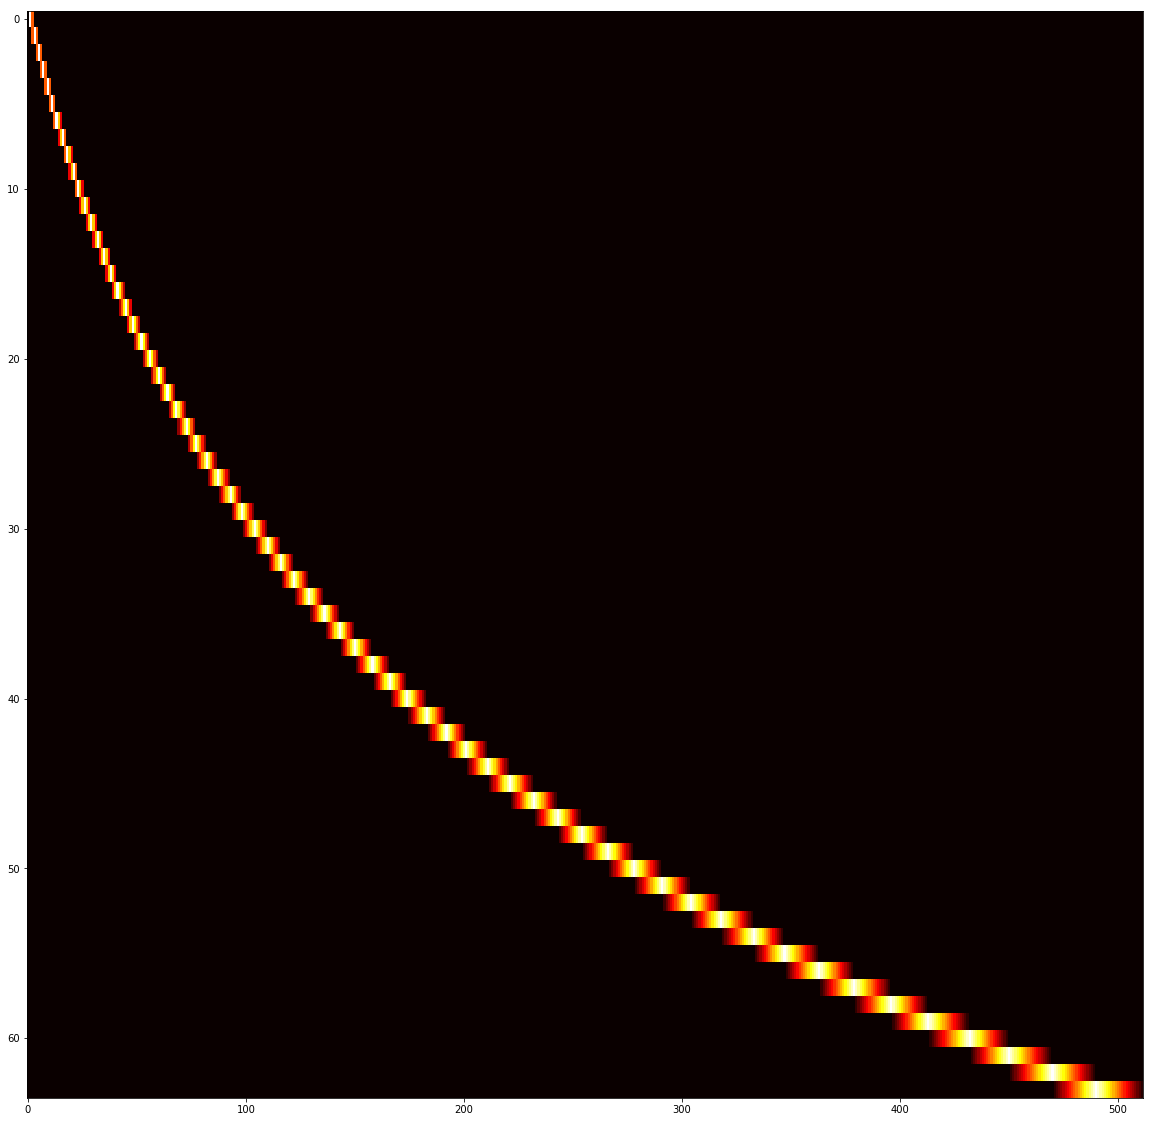

In [20]:
plt.figure(figsize = (20, 20))
plt.imshow(MEL_FILTERBANK_NPY.transpose(), cmap='hot', interpolation='nearest', aspect = 'auto')
plt.show()

In [21]:
# silent frame elimination
silent_frames = np.max(np.abs(train_X[0][rows].reshape(2048, -1)), axis = -1) >= SILENT_FRAME_AMT

In [22]:
x = 0

for i in xrange(0, 2048):
    wnd = train_X[0][rows[i]]
    if (not silent_frames[i]):
        plt.plot(wnd)
        plt.show()
        print np.max(np.abs(wnd))
        
        x = x + 1
        if (x > 5):
            break

In [23]:
# modify labels accordingly as well
labels[np.logical_not(silent_frames)] = 4.6

In [24]:
def l1_dist(x, y):
    return np.sum(np.abs(x - y), axis = 1).flatten()

l1_dist_baseline = l1_dist(clean, dirty)
l1_dist_baseline *= silent_frames
print np.corrcoef(l1_dist_baseline, labels)[1, 0]

-0.296058657756


In [25]:
def l2_dist(x, y):
    return np.sqrt(np.mean(np.square(x - y), axis = 1).flatten())

l2_dist_baseline = l2_dist(clean, dirty)
l2_dist_baseline *= silent_frames
print np.corrcoef(l2_dist_baseline, labels)[1, 0]

-0.304893666714


In [26]:
# BASELINE: MFCC vector distance
mfcc_dist_baseline = K.eval(perceptual_distance(clean.astype('float32'), dirty.astype('float32')))
mean = np.mean(mfcc_dist_baseline)
std = np.std(mfcc_dist_baseline)
print mean, std
print np.corrcoef(mfcc_dist_baseline, labels)[1, 0]

0.767687 1.28691
-0.532385946016


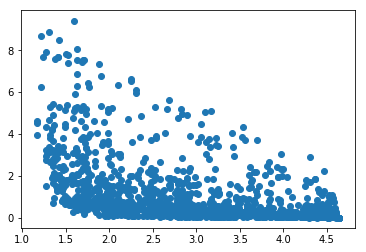

In [30]:
sorted_idxs = train_y[rows].argsort()
sorted_idxs = sorted_idxs[mfcc_dist_baseline[sorted_idxs] > 0]

x = train_y[rows][sorted_idxs]
y = mfcc_dist_baseline[sorted_idxs]

plt.scatter(x, y)
plt.show()